#Transfer-Learning: VGG19

##1. Preparación de los datos

In [ ]:
## CARGA DE DATOS
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_undersampling.rar'

In [ ]:
## ACELERACIÓN POR GPU
## =============================================================================

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17290448397893769106, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10879740785080880049
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
## Uso de Tensorflow 2.
## =============================================================================

%tensorflow_version 2.x

In [ ]:
## IMPORTACIÓN DE LAS LIBRERIAS NECESARIAS
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models    import Sequential, load_model
from tensorflow.keras.layers    import Add, Dense, Activation, GlobalAveragePooling2D, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprimimos en pantalla el resultado de todos los statements

In [ ]:
## DIRECTORIOS
## =============================================================================

base_dir =  'drive/MyDrive/TFM/Transfer-Learning/VGG19/'
train_dir = 'dataset_undersampling/train'
test_dir  = 'dataset_undersampling/test'

In [ ]:
## GENERADOR DE IMÁGENES (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,                 
        target_size = (224, 224), 
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  ='categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


##2. VGG16 (Modelo Base)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = VGG19(weights="imagenet",
                  include_top=False)

base_model.trainable = False                        

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 20,026,436
Trainable params: 2,052
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss='categorical_crossentropy', 
               optimizer= 'adam',
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'VGG19_Dense.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=60,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'VGG19_Dense_history.npy', history.history)

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'VGG19.h5')
history = np.load(base_dir + 'VGG19_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

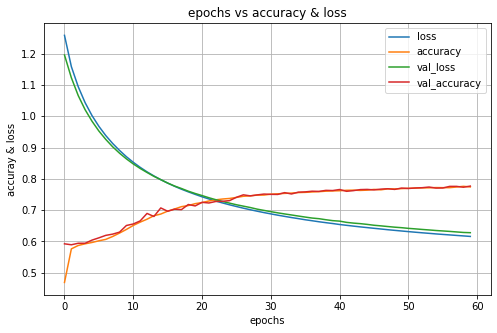

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 29s 285ms/step - loss: 0.6278 - accuracy: 0.7767


In [ ]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 1, 1, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

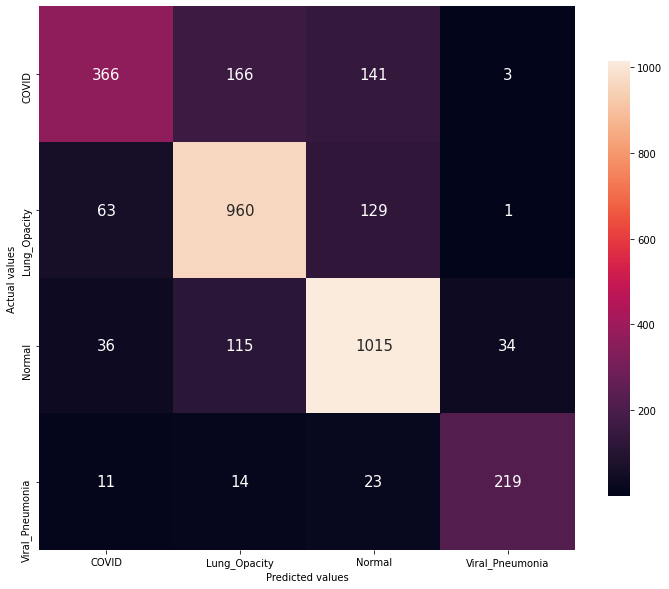

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.77      0.54      0.64       676
   Lung_Opacity       0.76      0.83      0.80      1153
         Normal       0.78      0.85      0.81      1200
Viral_Pneumonia       0.85      0.82      0.84       267

       accuracy                           0.78      3296
      macro avg       0.79      0.76      0.77      3296
   weighted avg       0.78      0.78      0.77      3296



##3. VGG19 (Modelo Base + 2 capas densas)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = VGG19(weights="imagenet",
                  include_top=False)

base_model.trainable = False                

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================
model.compile(loss='categorical_crossentropy', 
               optimizer= 'adam',
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'VGG19_Dense.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=60,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'VGG19_Dense_history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 148s 358ms/step - loss: 1.2166 - accuracy: 0.4672 - val_loss: 1.3077 - val_accuracy: 0.3953
Epoch 2/60
412/412 [==============================] - 147s 357ms/step - loss: 1.0100 - accuracy: 0.5776 - val_loss: 0.8531 - val_accuracy: 0.6475
Epoch 3/60
412/412 [==============================] - 147s 357ms/step - loss: 0.8939 - accuracy: 0.6313 - val_loss: 0.8936 - val_accuracy: 0.6605
Epoch 4/60
412/412 [==============================] - 147s 357ms/step - loss: 0.8075 - accuracy: 0.6668 - val_loss: 0.8008 - val_accuracy: 0.6126
Epoch 5/60
412/412 [==============================] - 147s 357ms/step - loss: 0.7941 - accuracy: 0.6716 - val_loss: 0.7639 - val_accuracy: 0.7096
Epoch 6/60
412/412 [==============================] - 147s 357ms/step - loss: 0.7295 - accuracy: 0.7078 - val_loss: 0.8034 - val_accuracy: 0.6845
Epoch 7/60
412/412 [==============================] - 147s 357ms/step - loss: 0.7230 - accuracy: 0.7061 - val_loss: 0.7976 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'VGG19_Dense.h5')
history = np.load(base_dir + 'VGG19_Dense_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

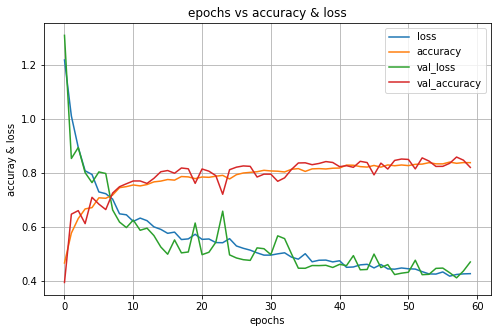

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 29s 285ms/step - loss: 0.4709 - accuracy: 0.8201


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

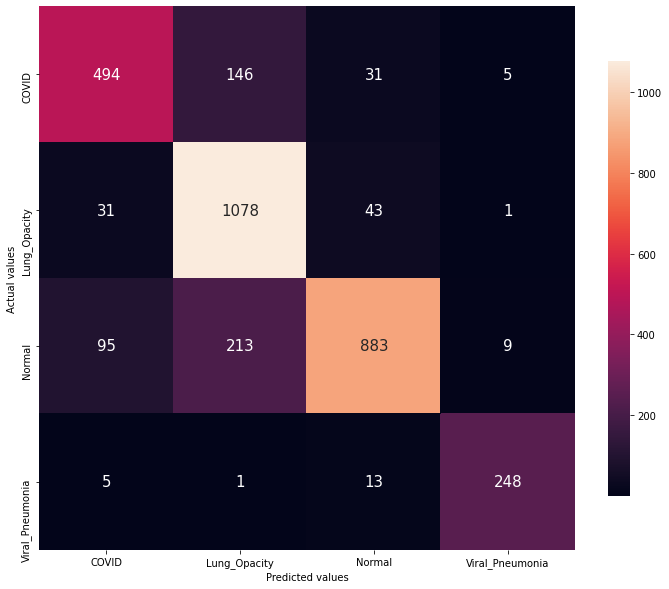

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.79      0.73      0.76       676
   Lung_Opacity       0.75      0.93      0.83      1153
         Normal       0.91      0.74      0.81      1200
Viral_Pneumonia       0.94      0.93      0.94       267

       accuracy                           0.82      3296
      macro avg       0.85      0.83      0.84      3296
   weighted avg       0.83      0.82      0.82      3296



##4. VGG16 (Modelo Base + 2 capas densas + últimas capas entrenables)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = VGG19(weights="imagenet",
                  include_top=False)

base_model.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
## DESBLOQUEO DE LAS ÚLTIMAS CAPAS CONVOLUCIONALES
## =============================================================================

base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv3', 'block5_conv4']:
        layer.trainable = True
    else:
        layer.trainable = False   

base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
## AÑADIDO DE DOS CAPAS DENSAS
## =============================================================================

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'VGG19_Last_Layer_Trainable_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=60,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'VGG19_Last_Layer_Trainable_history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 195s 380ms/step - loss: 0.6603 - accuracy: 0.7368 - val_loss: 0.3782 - val_accuracy: 0.8562
Epoch 2/60
412/412 [==============================] - 148s 359ms/step - loss: 0.3731 - accuracy: 0.8593 - val_loss: 0.3216 - val_accuracy: 0.8771
Epoch 3/60
412/412 [==============================] - 148s 359ms/step - loss: 0.3031 - accuracy: 0.8861 - val_loss: 0.2946 - val_accuracy: 0.8841
Epoch 4/60
412/412 [==============================] - 148s 359ms/step - loss: 0.2487 - accuracy: 0.9098 - val_loss: 0.3951 - val_accuracy: 0.8504
Epoch 5/60
412/412 [==============================] - 148s 359ms/step - loss: 0.2238 - accuracy: 0.9173 - val_loss: 0.3062 - val_accuracy: 0.8965
Epoch 6/60
412/412 [==============================] - 148s 359ms/step - loss: 0.1904 - accuracy: 0.9292 - val_loss: 0.3195 - val_accuracy: 0.8929
Epoch 7/60
412/412 [==============================] - 148s 358ms/step - loss: 0.1793 - accuracy: 0.9352 - val_loss: 0.3252 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'VGG19_Last_Layer_Trainable_model.h5')
history = np.load(base_dir + 'VGG19_Last_Layer_Trainable_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

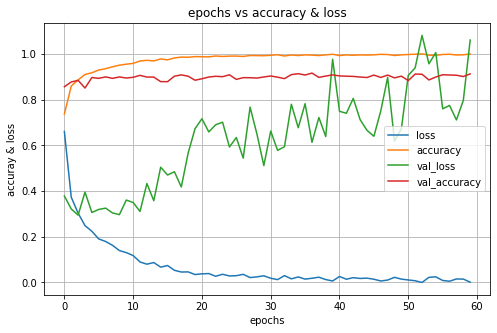

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 30s 288ms/step - loss: 1.0605 - accuracy: 0.9123


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

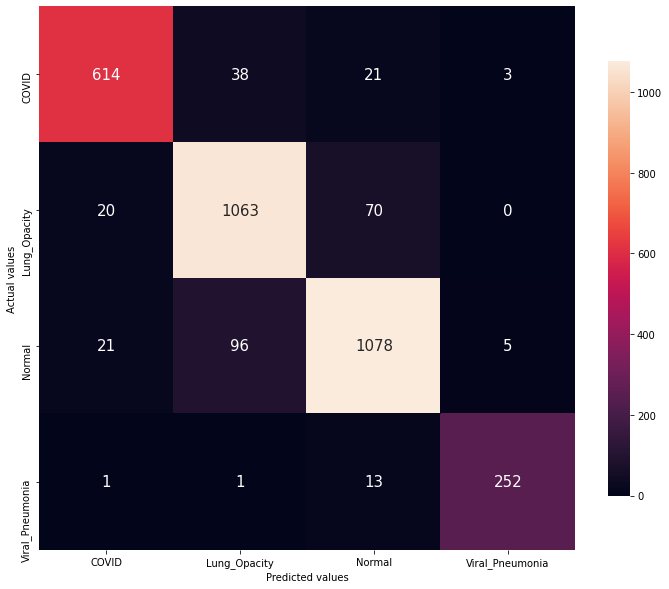

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## ======================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.94      0.91      0.92       676
   Lung_Opacity       0.89      0.92      0.90      1153
         Normal       0.91      0.90      0.91      1200
Viral_Pneumonia       0.97      0.94      0.96       267

       accuracy                           0.91      3296
      macro avg       0.93      0.92      0.92      3296
   weighted avg       0.91      0.91      0.91      3296

